# Requirements

In [5]:
import os, sys

pkg_path = 'D:\\Projects\\System_Trading\\JnQ\\'

os.chdir(pkg_path)

pakage_name = 'Bank'

# mpl_finance_path = 'D:\\python\\python38_1\\projects\\JnQ\\mpl_finance'
# ta_lib_path = 'D:\\python\\python38_1\\projects\\JnQ\\ta_lib'
funcs_path = pkg_path + 'funcs'

if funcs_path not in sys.path:

  try:
    # sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/JnQ')
    sys.path.insert(0, pkg_path + '\\{}'.format(pakage_name))
    sys.path.insert(0, funcs_path)
    # sys.path.insert(0, mpl_finance_path)
    # sys.path.insert(0, ta_lib_path)
    
  except Exception as e:
    print(e)


In [6]:
from funcs.kiwoom.pykiwoom import *

today = datetime.now()
todaystamp = today.year * 10000 + today.month * 100 + today.day 

np.seterr(invalid="ignore")
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=2000) 

pd.set_option('mode.chained_assignment',  None)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# KiwoomCustom

In [7]:
import math

class KiwoomCustom(Kiwoom):
    def __init__(self, logfile_name):
        super().__init__(logfile_name)
        
        # login
        self.comm_connect()
        if self.get_connect_state():
            print("connected.")
        else:
            print("disconnected.")            
        
        self.account_number = self.get_login_info("ACCNO").split(";")[0]
        self.password = "8974"  # Todo, temporarily direct declaration
        
        self.OnReceiveRealData.connect(self.receive_real_data)        
     
    def block_request(self, *args, **kwargs):
        trcode = args[0].lower()
        lines = parser.read_enc(trcode)
        self.tr_items = parser.parse_dat(trcode, lines)
        self.tr_record = kwargs["output"]
        next = kwargs["next"]

        # set input
        for id in kwargs:
            if id.lower() != "output" and id.lower() != "next":
                self.set_input_value(id, kwargs[id])

        # initialize
        self.received = False
        self.tr_remained = False

        # request
        self.comm_rq_data(trcode, trcode, next, "0101")
        while not self.received:
            pythoncom.PumpWaitingMessages()

        return self.tr_data
    
    def get_available_balance(self):

        self.set_input_value("계좌번호", self.account_number)
        self.set_input_value("비밀번호", self.password)
        self.set_input_value("비밀번호입력매체구분", "00")
        self.set_input_value("조회구분", "3")
        self.comm_rq_data("예수금상세현황요청", "opw00001", 0, "2000")

        self.set_input_value("계좌번호", self.account_number)
        self.set_input_value("비밀번호", self.password)
        self.comm_rq_data("계좌평가잔고내역요청", "opw00018", 0, "2000")
        while self.inquiry == '2':
            time.sleep(0.2)
            self.set_input_value("계좌번호", self.account_number)
            self.set_input_value("비밀번호", self.password)
            self.comm_rq_data("계좌평가잔고내역요청", "opw00018", 2, "2000")
            
        return self.data_opw00001
    
    def get_order_info(self):
        
        """
        계좌번호 = 전문 조회할 보유계좌번호
        SetInputValue("계좌번호"	,  "입력값 1");
        전체종목구분 = 0:전체, 1:종목
        SetInputValue("전체종목구분"	,  "입력값 2");
        매매구분 = 0:전체, 1:매도, 2:매수
        SetInputValue("매매구분"	,  "입력값 3");
        종목코드 = 전문 조회할 종목코드 (공백허용, 공백입력시 전체종목구분 "0" 입력하여 전체 종목 대상으로 조회)
        SetInputValue("종목코드"	,  "입력값 4");
        체결구분 = 0:전체, 2:체결, 1:미체결
        SetInputValue("체결구분"	,  "입력값 5");
        """
        
        # 미체결요청
        self.set_input_value("계좌번호", self.account_number)
        self.set_input_value("전체종목구분", 0)
        self.set_input_value("매매구분", "0")
        self.set_input_value("종목코드", "")
        self.set_input_value("체결구분", "0")
        self.comm_rq_data("미체결요청", "opt10075", 0, "2000")
       
    # def get_order_info(self, code, account_number, order_id): 
    #     # 체결요청
    #     self.set_input_value("종목코드", code)
    #     self.set_input_value("조회구분", 0)
    #     self.set_input_value("매도수구분", "0")
    #     self.set_input_value("계좌번호", account_number)
    #     self.set_input_value("비밀번호", "")
    #     self.set_input_value("주문번호", order_id)
    #     self.set_input_value("체결구분", "0")
    #     self.comm_rq_data("체결요청", "opt10076", 0, "2000")
        
        return        
        
    def calc_with_hoga_unit(self, price):

        """
        1. 체결을 고려해 올림을 기본으로 함 (+ 1 을 한 이유.)
        """

        hoga_unit = self.get_hoga_unit(price)

        return ((price // hoga_unit) + 1) * hoga_unit
    
    def on_receive_tr_data(self, screen_no, request_name, tr_code, record_name, inquiry, unused0, unused1, unused2,
                           unused3):
        """
        TR 수신 이벤트
        조회요청 응답을 받거나 조회데이터를 수신했을 때 호출됩니다.
        request_name tr_code comm_rq_data()메소드의 매개변수와 매핑되는 값 입니다.
        조회데이터는 이 이벤트 메서드 내부에서 comm_get_data() 메서드를 이용해서 얻을 수 있습니다.
        :param screen_no: string - 화면번호(4자리)
        :param request_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 requestName)
        :param tr_code: string
        :param record_name: string
        :param inquiry: string - 조회('0': 남은 데이터 없음, '2': 남은 데이터 있음)
        """

        print("on_receive_tr_data 실행: screen_no: %s, request_name: %s, tr_code: %s, record_name: %s, inquiry: %s" % (
            screen_no, request_name, tr_code, record_name, inquiry))

        # 주문번호와 주문루프
        self.order_no = self.comm_get_data(tr_code, "", request_name, 0, "주문번호")

        try:
            self.order_loop.exit()
        except AttributeError:
            pass

        self.inquiry = inquiry        

        if request_name == "예수금상세현황요청":   
            
            key_list = ["예수금", "주문가능금액", "d+1추정예수금", "d+2추정예수금"]
            for key in key_list:
                value = self.comm_get_data(tr_code, "", request_name, 0, key)
                # print(key, value)
                
                if key == "주문가능금액":                
                    self.data_opw00001 = value

        if request_name == '계좌평가잔고내역요청':
            
            # init data_opw00018            
            self.data_opw00018 = {'account_evaluation': [], 'stocks': []}
            
            # 계좌 평가 정보
            account_evaluation = []
            key_list = ["총매입금액", "총평가금액", "총평가손익금액", "총수익률(%)", "추정예탁자산"]

            for key in key_list:
                value = self.comm_get_data(tr_code, "", request_name, 0, key)
                # print(key, value)

                if key.startswith("총수익률"):
                    value = self.change_format(value, 2)
                else:
                    value = self.change_format(value)
                    
                account_evaluation.append(value)
            self.data_opw00018['account_evaluation'] = account_evaluation

            # 보유 종목 정보
            cnt = self.get_repeat_cnt(tr_code, request_name)
            key_list = ["종목명", "보유수량", "매입가", "현재가", "평가손익", "수익률(%)", "종목번호"]
            
            # 보유 종목 별로 stock 에 list 로 담기
            for i in range(cnt):
                stock = []
                for key in key_list:
                    value = self.comm_get_data(tr_code, "", request_name, i, key)
                    # print(key, value)
                    
                    if key.startswith("수익률"):
                        value = self.change_format(value, 2)
                    elif key != "종목명" and key != "종목번호":
                        value = self.change_format(value)
                        
                    stock.append(value)                    
                self.data_opw00018['stocks'].append(stock)
                
        if request_name == '미체결요청':
            
            key_list = ["종목코드", "종목명", "주문상태", "주문수량", "미체결수량", "수익률(%)", "종목번호"]
            for key in key_list:
                value = self.comm_get_data(tr_code, "", request_name, 0, key)
                print(key, value, type(value))
                
        try:
            self.request_loop.exit()
        except AttributeError:
            pass
    

    def receive_real_data(self, code, real_type, real_data):
        
        """
        실시간 데이터 수신 이벤트
        실시간 데이터를 수신할 때 마다 호출되며,
        set_real_reg() 메서드로 등록한 실시간 데이터도 이 이벤트 메서드에 전달됩니다.
        get_comm_real_data() 메서드를 이용해서 실시간 데이터를 얻을 수 있습니다.
        :param code: string - 종목코드
        :param real_type: string - 실시간 타입(KOA의 실시간 목록 참조)
        :param real_data: string - 실시간 데이터 전문
        """

        data = []

        try:
            self.log.debug("[receiveRealData]")
            self.log.debug("({})".format(real_type))

            if real_type not in RealType.REALTYPE:
                return

            if code != "":
                data.append(code)
                codeOrNot = code
            else:
                codeOrNot = real_type

            for fid in sorted(RealType.REALTYPE[real_type].keys()):
                value = self.get_comm_real_data(codeOrNot, fid)
                data.append(value)

            # TODO: DB에 저장
            self.log.debug(data)

        except Exception as e:
            self.log.error('{}'.format(e))

        return data

    @staticmethod
    def change_format(data, mode=0):
        
        # string 맘에 안들어서 일단은 모두 숫자로 변경함.
        if mode == 0:
            format_data = int(data)
        elif mode == 2:
            format_data = float(data) / 100
            
        return format_data
    
    @staticmethod
    def get_hoga_unit(price):

        if price < 2000:
            return 1
        elif price < 5000:
            return 5
        elif price < 20000:
            return 10
        elif price < 50000:
            return 50
        elif price < 200000:
            return 100
        elif price < 500000:
            return 500
        else:
            return 1000        

    @staticmethod
    def calc_with_precision(data, data_precision, def_type='floor'):
        
        """        
        1. quantity 는 Stock 특성상 '0' precision 사용함.
        """

        if not pd.isna(data):
            if data_precision > 0:
                if def_type == 'floor':
                    data = math.floor(data * (10 ** data_precision)) / (10 ** data_precision)
                elif def_type == 'round':
                    data = float(round(data, data_precision))
                else:
                    data = math.ceil(data * (10 ** data_precision)) / (10 ** data_precision)
            else:
                data = int(data)

        return data

## login

In [8]:
app = QApplication(sys.argv)
kiwoom = KiwoomCustom('D:\Projects\System_Trading\PyTrader\logging.conf')

on_receive_tr_data 실행: screen_no: 0102, request_name: 서버구분, tr_code: KOA_NORMAL_BUY_KP_ORD, record_name: , inquiry: 
connected.


## get_available_balance

In [ ]:
available_balance = kiwoom.get_available_balance()
# available_balance = get_available_balance(kiwoom)

print(available_balance)
print(kiwoom.data_opw00018['account_evaluation'])  # 총매입 총평가 총손익 수익 ? 추정자산
print(kiwoom.data_opw00018['stocks'])

## realtime price

In [10]:
"""
use for realtime price
"""     
def get_market_price_v2(self):
    while 1:
        res = self.connections[0].price
        if res is not None:
            return res

        
code = "064480"
real_type = "주식시세"
real_data = "10"

while 1:
    
    data = kiwoom.receive_real_data("064480", real_type, real_data)
    print("data :", data)
    time.sleep(1)

2023-02-27 08:47:32,872 - Kiwoom - DEBUG    - [receiveRealData]
2023-02-27 08:47:32,872 - Kiwoom - DEBUG    - (주식시세)
2023-02-27 08:47:32,873 - Kiwoom - DEBUG    - ['064480', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
data : ['064480', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
2023-02-27 08:47:33,885 - Kiwoom - DEBUG    - [receiveRealData]
2023-02-27 08:47:33,885 - Kiwoom - DEBUG    - (주식시세)
2023-02-27 08:47:33,886 - Kiwoom - DEBUG    - ['064480', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
data : ['064480', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
2023-02-27 08:47:34,897 - Kiwoom - DEBUG    - [receiveRealData]
2023-02-27 08:47:34,897 - Kiwoom - DEBUG    - (주식시세)
2023-02-27 08:47:34,898 - Kiwoom - DEBUG    - ['064480', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
data : ['064480', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
2023-02-27 08:47

KeyboardInterrupt: 

## precision (hoga_unit)

In [10]:
kiwoom.calc_with_hoga_unit(6888)
# calc_with_precision(102.34, 0)

6890

## get_order_info

In [7]:
def get_order_info(self):
        
        """
        계좌번호 = 전문 조회할 보유계좌번호
        SetInputValue("계좌번호"	,  "입력값 1");
        전체종목구분 = 0:전체, 1:종목
        SetInputValue("전체종목구분"	,  "입력값 2");
        매매구분 = 0:전체, 1:매도, 2:매수
        SetInputValue("매매구분"	,  "입력값 3");
        종목코드 = 전문 조회할 종목코드 (공백허용, 공백입력시 전체종목구분 "0" 입력하여 전체 종목 대상으로 조회)
        SetInputValue("종목코드"	,  "입력값 4");
        체결구분 = 0:전체, 2:체결, 1:미체결
        SetInputValue("체결구분"	,  "입력값 5");
        """
        
        # 미체결요청
        self.set_input_value("계좌번호", self.account_number)
        self.set_input_value("전체종목구분", 0)
        self.set_input_value("매매구분", "0")
        self.set_input_value("종목코드", "")
        self.set_input_value("체결구분", "2")
        self.comm_rq_data("미체결요청", "opt10075", 0, "2000")

In [8]:
# kiwoom.get_order_info()
get_order_info(kiwoom)

return_code : 0
on_receive_tr_data 실행: screen_no: 2000, request_name: 미체결요청, tr_code: opt10075, record_name: , inquiry: 0
종목코드  <class 'str'>
종목명  <class 'str'>
주문상태  <class 'str'>
주문수량  <class 'str'>
미체결수량  <class 'str'>
수익률(%)  <class 'str'>
종목번호  <class 'str'>


In [ ]:
# kiwoom.on_receive_chejan_data
# kiwoom.GetChejanData(910)
kiwoom.on_receive_chejan_data("1", 1, "9203")

### staticmethod

In [11]:
   
"""
체결요청 기준으로 가능해보임 (미체결요청보다, 차라리 체결 요청 기준하는게 나을 것도 같음.
"""
@staticmethod
def get_exec_price(order_info):
    if order_info.origType == OrderType.LIMIT:
        exec_price = float(order_info.price)
    else:
        exec_price = float(order_info.avgPrice)

    return exec_price

@staticmethod
def get_exec_qty(order_info):
    return float(order_info.executedQty)

@staticmethod
def get_exec_ratio(order_info):
    return float(order_info.executedQty) / float(order_info.origQty)

@staticmethod
def check_execution(order_info, qty_precision):
    return (float(order_info.origQty) - float(order_info.executedQty)) < 1 / (10 ** qty_precision)


@staticmethod
def get_precision_by_price(price):
    try:
        precision = len(str(price).split('.')[1])
    except Exception as e:
        precision = 0
    return precision

# Get ticker data

## 분봉차트 조회요청

In [6]:
"""
종목코드 = 전문 조회할 종목코드
SetInputValue("종목코드"	,  "입력값 1");

틱범위 = 1:1분, 3:3분, 5:5분, 10:10분, 15:15분, 30:30분, 45:45분, 60:60분
SetInputValue("틱범위"	,  "입력값 2");

수정주가구분 = 0 or 1, 수신데이터 1:유상증자, 2:무상증자, 4:배당락, 8:액면분할, 16:액면병합, 32:기업합병, 64:감자, 256:권리락
SetInputValue("수정주가구분"	,  "입력값 3");
"""

trcode = "opt10080"

input_1 = "064090"
input_2 = "1"
input_3 = "0"

columns = ['체결시간', '시가', '고가', '저가', '현재가', '거래량']
new_columns=['index', 'open', 'high', 'low', 'close', 'volume']

save_mode = 0
database_path = 'D:\\Projects\\System_Trading\\JnQ\\database\\kiwoom\\non_cum'
date = "2023-02-23"
os.makedirs(os.path.join(database_path, date), exist_ok=True)

try:
    df_min_chart = kiwoom.block_request(trcode,
                              종목코드=input_1,
                              틱범위=input_2,
                              수정주가구분=input_3,
                              output="주식분봉차트조회",
                              next=0)
    
    # 1. col_name 변경
    # 2. index 수정 및 data type integer 사용
    new_df = df_min_chart[columns]
    new_df.columns = new_columns
    new_df = new_df.set_index('index').astype(int).abs()
    
    # 3. 시계열 순서로 데이터 정렬 및 index datetime type 으로 변환.
    if new_df.index.dtype != str:
        timeindex = pd.to_datetime(new_df.index.astype(str))
        new_df.index = timeindex
        new_df = new_df.sort_index()
        
    # 4. check save.
    if save_mode:
        data_save_name = "{} {}.pkl".format(date, input_1)
        data_save_path = os.path.join(database_path, date, data_save_name)

        new_df.to_pickle(data_save_path)
        print(data_save_path, "saved")
        
except Exception as e:
    print(e)

return_code : 0
on_receive_tr_data 실행: screen_no: 0101, request_name: opt10080, tr_code: opt10080, record_name: , inquiry: 2


KeyboardInterrupt: 

In [7]:
new_df.loc["2023-02-23 15:13:00":"2023-02-24 11:13:00"] #.index

NameError: name 'new_df' is not defined

## 전일대비등락률상위요청

In [40]:
"""
시장구분 = 000:전체, 001:코스피, 101:코스닥
SetInputValue("시장구분"	,  "입력값 1");

정렬구분 = 1:상승률, 2:상승폭, 3:하락률, 4:하락폭, 5:보합
SetInputValue("정렬구분"	,  "입력값 2");

거래량조건 = 0000:전체조회, 0010:만주이상, 0050:5만주이상, 0100:10만주이상, 0150:15만주이상, 0200:20만주이상, 0300:30만주이상, 0500:50만주이상, 1000:백만주이상
SetInputValue("거래량조건"	,  "입력값 3");

종목조건 = 0:전체조회, 1:관리종목제외, 4:우선주+관리주제외, 3:우선주제외, 5:증100제외, 6:증100만보기, 7:증40만보기, 8:증30만보기, 9:증20만보기, 11:정리매매종목제외, 12:증50만 보기, 13:증60만 보기, 14:ETF제외, 15:스팩제외, 16:ETF+ETN제외
SetInputValue("종목조건"	,  "입력값 4");

신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 5:신용한도초과제외, 8:신용대주, 9:신용융자전체
SetInputValue("신용조건"	,  "입력값 5");

상하한포함 = 0:불 포함, 1:포함
SetInputValue("상하한포함"	,  "입력값 6");

가격조건 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~5천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상, 10:1만원미만
SetInputValue("가격조건"	,  "입력값 7");

거래대금조건 = 0:전체조회, 3:3천만원이상, 5:5천만원이상, 10:1억원이상, 30:3억원이상, 50:5억원이상, 100:10억원이상, 300:30억원이상, 500:50억원이상, 1000:100억원이상, 3000:300억원이상, 5000:500억원이상
SetInputValue("거래대금조건"	,  "입력값 8");
"""

trcode = "opt10027"

input_1 = "101"
input_2 = "1"
input_3 = "0000"
input_4 = "0"
input_5 = "0"
input_6 = "1"
input_7 ="0"
input_8 ="0"

try:
    df_high_fluc = kiwoom.block_request(trcode,
                              시장구분=input_1,
                              정렬구분=input_2,
                              거래량조건=input_3,
                              종목조건=input_4,
                              신용조건=input_5,
                              상하한포함=input_6,
                              가격조건=input_7,
                              거래대금조건=input_8,
                              output="전일대비등락률상위",
                              next=0)
except Exception as e:
    print(e)

{'trcode': 'opt10027', 'input': [{'전일대비등락률상위요청': ['시장구분', '정렬구분', '거래량조건', '종목조건', '신용조건', '상하한포함', '가격조건', '거래대금조건']}], 'output': [{'전일대비등락률상위': ['종목분류', '종목코드', '종목명', '현재가', '전일대비기호', '전일대비', '등락률', '매도잔량', '매수잔량', '현재거래량', '체결강도', '횟수']}]}


### 상위 종목 데이터 수집

In [49]:
columns = ['체결시간', '시가', '고가', '저가', '현재가', '거래량']
new_columns=['index', 'open', 'high', 'low', 'close', 'volume']

save_mode = 1
database_path = 'D:\\Projects\\System_Trading\\JnQ\\database\\kiwoom\\non_cum'
date = str(new_df.index[-1]).split(" ")[0]
os.makedirs(os.path.join(database_path, date), exist_ok=True)

if save_mode:    
    rank_save_path = os.path.join(database_path, date, "rank.pkl")
    df_high_fluc.종목코드.to_pickle(rank_save_path)
    print(rank_save_path, "saved")

for input_1 in df_high_fluc.종목코드:    
    try:
        df_min_chart = kiwoom.block_request("opt10080",
                                  종목코드=input_1,
                                  틱범위=input_2,
                                  수정주가구분=input_3,
                                  output="주식분봉차트조회",
                                  next=0)

        # 1. col_name 변경
        # 2. index 수정 및 data type integer 사용
        new_df = df_min_chart[columns]
        new_df.columns = new_columns
        new_df = new_df.set_index('index').astype(int).abs()

        # 3. 시계열 순서로 데이터 정렬 및 index datetime type 으로 변환.
        if new_df.index.dtype != str:
            timeindex = pd.to_datetime(new_df.index.astype(str))
            new_df.index = timeindex
            new_df = new_df.sort_index()

        # 4. check save.
        if save_mode:
            data_save_name = "{} {}.pkl".format(date, input_1)
            data_save_path = os.path.join(database_path, date, data_save_name)

            new_df.to_pickle(data_save_path)
            print(data_save_path, "saved")

    except Exception as e:
        print(e)
        
    """kiwoom API limit term"""
    time.sleep(0.5)

D:\Projects\System_Trading\JnQ\database\kiwoom\non_cum\2023-02-24\rank.pkl saved


SyntaxError: 'break' outside loop (1913775972.py, line 14)

## 상하한가 요청

In [3]:
'''
시장구분 = 000:전체, 001:코스피, 101:코스닥
상하한구분 = 1:상한, 2:상승, 3:보합, 4: 하한, 5:하락, 6:전일상한, 7:전일하한
정렬구분 = 1:종목코드순, 2:연속횟수순(상위100개), 3:등락률순
종목조건 = 0:전체조회,1:관리종목제외, 3:우선주제외, 4:우선주+관리종목제외, 5:증100제외, 6:증100만 보기, 7:증40만 보기, 8:증30만 보기, 9:증20만 보기, 10:우선주+관리종목+환기종목제외
거래량구분 = 00000:전체조회, 00010:만주이상, 00050:5만주이상, 00100:10만주이상, 00150:15만주이상, 00200:20만주이상, 00300:30만주이상, 00500:50만주이상, 01000:백만주이상
신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 9:신용융자전체
매매금구분 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~3천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상
'''

trcode = "opt10017"
market = "001"  # kospi
updown = "2"
sort = "3"
ticker_cond = "0"
volume_cond = "0000"
debt_cond = "0"
price_cond ="0"

df = kiwoom.block_request(trcode,
                          시장구분=market,
                          상하한구분=updown,
                          정렬구분=sort,
                          종목조건=ticker_cond,
                          거래량구분=volume_cond,
                          신용조건=debt_cond,
                          매매금구분=price_cond,
                          output="상하한가",
                          next=0)

{'trcode': 'opt10017', 'input': [{'상하한가요청': ['시장구분', '상하한구분', '정렬구분', '종목조건', '거래량구분', '신용조건', '매매금구분']}], 'output': [{'상하한가': ['종목코드', '종목정보', '종목명', '현재가', '전일대비기호', '전일대비', '등락률', '거래량', '전일거래량', '매도잔량', '매도호가', '매수호가', '매수잔량', '횟수']}]}


## 가격급등락 요청

In [3]:
'''
시장구분 = 000:전체, 001:코스피, 101:코스닥, 201:코스피200
등락구분 = 1:급등, 2:급락
시간구분 = 1:분전, 2:일전
시간 = 분 혹은 일입력
거래량구분 = 00000:전체조회, 00010:만주이상, 00050:5만주이상, 00100:10만주이상, 00150:15만주이상, 00200:20만주이상, 00300:30만주이상, 00500:50만주이상, 01000:백만주이상
종목조건 = 0:전체조회,1:관리종목제외, 3:우선주제외, 5:증100제외, 6:증100만보기, 7:증40만보기, 8:증30만보기
신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 9:신용융자전체
가격조건 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~3천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상
상하한포함 = 0:미포함, 1:포함
'''

trcode = "opt10019" # opt10001"
market = "001"  # kospi
updown = "1"
timeunit = "2"
timeunit_cnt = "1"
volume_cond = "0000"
ticker_cond = "0"
debt_cond = "0"
price_cond ="0"
limit_price_cond = "0"

df = kiwoom.block_request(trcode,
                          시장구분=market,
                          등락구분=updown,
                          시간구분=timeunit,
                          시간=timeunit_cnt,
                          거래량구분=volume_cond,
                          종목조건=ticker_cond,
                          신용조건=debt_cond,
                          가격조건=price_cond,
                          상하한포함=limit_price_cond,
                          output="가격급등락",
                          next=0)


# kwargs = {"종목코드": code_str, "output": "주식기본정보", "next": 0}
# df = kiwoom.block_request(args=args)
# df = kiwoom.block_request(trcode, kwargs)

# code_str = "005930"

{'trcode': 'opt10019', 'input': [{'가격급등락요청': ['시장구분', '등락구분', '시간구분', '시간', '거래량구분', '종목조건', '신용조건', '가격조건', '상하한포함']}], 'output': [{'가격급등락': ['종목코드', '종목분류', '종목명', '전일대비기호', '전일대비', '등락률', '기준가', '현재가', '기준대비', '거래량', '급등률']}]}


# Get creon data

In [2]:

## 종목 데이터 호출 Class
class StockChart:
    def __init__(self, stock_code):
        self.CpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
        self.StockChart = win32com.client.Dispatch("CpSysDib.StockChart")
        self.CpStatus = win32com.client.Dispatch("CpUtil.CpCybos")

        '''
        파라미터 종류
        stock_code : 종목코드
        flag : 호출 데이터(거래대금까지, 매매동향까지)
        '''

        self.stock_code = stock_code

        ## 입력 변수에 따른 호출데이터 설정
        self.start_date = self.CpCodeMgr.GetstockListedDate(stock_code)


    ## 데이터 호출 후 대기 시간 확인용
    def checkRemainTime(self):
        remainTime = self.CpStatus.LimitRequestRemainTime
        remainCount = self.CpStatus.GetLimitRemainCount(1) # 시세 제한 갯수
 
        if remainCount <= 0:
                timeStart = time.time()
                while remainCount <= 0 :
                    time.sleep(remainTime/1000)
                    remainCount = self.CpStatus.GetLimitRemainCount(1)  # 시세 제한
                    remainTime = self.CpStatus.LimitRequestRemainTime   
                ellapsed = time.time() - timeStart
                print("수신 대기: %.2f 초" %ellapsed)


    ## 분, 틱 데이터 호출 Method
    def call_stock_data_minute_tick(self, period, todaystamp=0, adjusted=0):

        fromDate = self.CpCodeMgr.GetstockListedDate(self.stock_code)        
        count = 9999999
        data_array_price_volume = [0, 1, 2, 3, 4, 5, 8]

        self.StockChart.SetInputValue(0, self.stock_code)  # 종목코드
        self.StockChart.SetInputValue(1, ord('2'))  # 갯수로 받기
        self.StockChart.SetInputValue(4, count)  # 갯수
        self.StockChart.SetInputValue(5, data_array_price_volume) # 호출 데이터
        self.StockChart.SetInputValue(6, ord('m')) # 차트 구분 (분)
        self.StockChart.SetInputValue(7, period) # 분봉 단위
        # self.StockChart.SetInputValue(9, ord('1'))  # 수정주가 사용
        self.StockChart.SetInputValue(9, ord(str(adjusted)))  # 수정주가 사용

        # raw_data_column = ('Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TradeVolume')
        raw_data_column = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

        stock_raw_data = []
        receive_data = {} ## 딕셔너리 형태

        for col in raw_data_column:
            receive_data[col] = []

        receive_count = 0

        while count > receive_count:
            self.StockChart.BlockRequest()  # 요청 후 응답 대기
            self.checkRemainTime()

            receive_batch_len = self.StockChart.GetHeaderValue(3)  # 받아온 데이터 개수
            receive_batch_len = min(receive_batch_len, count - receive_count) # 정확히 count 개수만큼 받기 위함

            ## 데이터 수신하여 딕셔너리에 저장
            for i in range(receive_batch_len):
                for col_idx, col in enumerate(raw_data_column):
                    receive_data[col].append(self.StockChart.GetDataValue(col_idx, i))

            receive_count += receive_batch_len
            ## print('{} / {}'.format(receive_count, count))

            # 서버가 가진 모든 데이터를 요청한 경우 break.
            if not self.StockChart.Continue:
                break

        ## 날짜와 분봉의 합치
        # receive_data['Date'] = list(map(lambda x, y: int('{}{:04}'.format(x, y)), receive_data['Date'], receive_data['Time']))
        receive_data['date'] = list(map(lambda x, y: ('{}{:04}'.format(x, y)), receive_data['date'], receive_data['time']))
        del receive_data['time']
        raw_data_column.remove('time')
        ## 데이터프레임 형태로 변환
        ## 다만 호출한 데이터를 그대로 쓰게되면 날짜가 최신 -> 옛날순으로 가므로 리버스해서 역순에서 정순을 바꿔준다.
        # stock_raw_data = pd.DataFrame(receive_data, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'TradeVolume'])
        stock_raw_data = pd.DataFrame(receive_data, columns=['open', 'high', 'low', 'close', 'volume'], index=receive_data['date'])        
        
        timeIndex = pd.to_datetime(stock_raw_data.index.astype(str))
        stock_raw_data.index = timeIndex
        stock_raw_data = stock_raw_data.sort_index() # 마지막 행이 최신 데이터

        return stock_raw_data # [::-1]


## 호출한 주가 데이터를 DB 파일로 저장
class ExportDatabase:
    def __init__(self, period, code_list, adjusted, base_date, data_len_thr):
        self.CpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
        self.code_list = code_list
        self.period = period
        self.adjusted = adjusted
        self.base_date = base_date
        self.data_len_thr = data_len_thr

    ## 데이터 수신하여 DB파일에 저장
    def MakeDatabase(self):

        ## 분봉 데이터 저장(분단위 별로 나누어 저장)
        kospi = self.CpCodeMgr.GetstockListByMarket(1) # 코스피
        kosdaq = self.CpCodeMgr.GetstockListByMarket(2) # 코스닥
        
        # code_list = ['A005930' ] #, 'A233740', 'A229200', 'A251340', 'A069500', 'A119200', 'A122630', 'A252670']
        code_list = self.code_list #, 'A233740', 'A229200', 'A251340', 'A069500', 'A119200', 'A122630', 'A252670']

        # base_date = datetime.today().strftime('%Y%m%d')
        base_date = self.base_date
        
        save_path = 'D:\\Projects\\System_Trading\\JnQ\\candlestick_concated\\database_creon\\cum\\{}'.format(base_date)
        os.makedirs(save_path, exist_ok=True)
        
        ## 분봉 데이터 저장(분단위 별로 나누어 저장)
        if type(self.period) is int:
            print('%s분봉 데이터 수집' %self.period)
            # con = sqlite3.connect('stock_data_%sminute.db' %self.period)

            for i in range(len(code_list)):
                stockchart = StockChart(code_list[i])
                # stock_raw_data = stockchart.call_stock_data_minute_tick(self.period, adjusted=self.adjusted)
                
                # 유효구간 검증 logic
                stock_raw_data_0 = stockchart.call_stock_data_minute_tick(self.period, adjusted=0)
                
                if len(stock_raw_data_0) < self.data_len_thr:
                    continue
                    
                stock_raw_data_1 = stockchart.call_stock_data_minute_tick(self.period, adjusted=1)
                assert len(stock_raw_data_0) == len(stock_raw_data_1)
                valid_idx = np.where(stock_raw_data_0.close == stock_raw_data_1.close)[0]
                
                # save_name = '%s %s_%s.csv' % (base_date, code, tick_range)
                # df.to_csv(os.path.join(save_path, save_name))

                save_name = '%s %s_%s_%s.parquet' % (base_date, code_list[i], self.period, self.adjusted)                
                
                # stock_raw_data_0.iloc[:valid_idx[-1]].to_parquet(os.path.join(save_path, save_name), engine='fastparquet')
                stock_raw_data_0.iloc[valid_idx[0]:].to_parquet(os.path.join(save_path, save_name), engine='fastparquet')

                # stock_raw_data.to_sql(str(code_list[i]), con, if_exists='replace')
                print("[%s / %s] %s 수집 완료" %(i+1, len(code_list), code_list[i]))
                i += 1

        else:
            # con = sqlite3.connect('stock_data_%s.db' %self.period)
            for i in range(len(code_list)):
                stockchart = StockChart(code_list[i])
                stock_raw_data = stockchart.call_stock_data_minute_tick(self.periodd, adjusted=self.adjusted)               

                save_name = '%s %s_%s_%s.parquet' % (base_date, code_list[i], self.period, self.adjusted)
                stock_raw_data.to_parquet(os.path.join(save_path, save_name), engine='fastparquet')
                
                # stock_raw_data.to_sql(str(code_list[i]), con, if_exists='replace')
                print("[%s / %s] %s 수집 완료" %(i+1, len(code_list), code_list[i]))
                i += 1            




In [3]:


## 데이터베이스 제작 시간간격
# calender_period = ['day', 'month', 'year']
## time_period = [1, 3, 5, 10, 30, 60, 180]

time_period = [1] # min
# incond_ticker_codes = ["610054"]
# incond_ticker_codes = ['A005930']
incond_ticker_codes = ['024830', '015710', '033320', '064090', '011810', '177350', '052020', '006220', '073640']
incond_ticker_codes = ['A' + code_ for code_ in incond_ticker_codes]
adjusted = 0 # 미수정 주가
base_date = "20221228"
data_len_thr = 3000

## 분봉 데이터베이스 제작
for i in range(len(time_period)):
    MakeDataBase = ExportDatabase(time_period[i], incond_ticker_codes, adjusted, base_date, data_len_thr)
    MakeDataBase.MakeDatabase()

1분봉 데이터 수집
수신 대기: 1.06 초
[2 / 9] A015710 수집 완료
[3 / 9] A033320 수집 완료
수신 대기: 3.20 초
[4 / 9] A064090 수집 완료
수신 대기: 1.15 초
수신 대기: 2.97 초
[5 / 9] A011810 수집 완료
수신 대기: 3.01 초
[6 / 9] A177350 수집 완료
수신 대기: 2.81 초
[7 / 9] A052020 수집 완료
수신 대기: 2.67 초
수신 대기: 2.32 초
[8 / 9] A006220 수집 완료
수신 대기: 2.19 초
[9 / 9] A073640 수집 완료


## load creon data

In [5]:
save_path = 'candlestick_concated/database_creon/'

date = "20221228"
# date = "2022-10-24"
pkg_path = 'D:\\Projects\\System_Trading\\JnQ\\'

data_path = os.path.join(pkg_path, save_path, "cum", date)

# ------ load ftr list ------ #
# ticker = 'A003075' # ETH RUNE FTM
# data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s]
# data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if ticker in s if '_0.' in s]
data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if '_0.' in s]
print(data_list)

start_0 = time.time()
key = data_list[0]  # tempoaray use single key
# res_df_ = pd.read_csv(os.path.join(data_path, key), index_col=0) # .set_index("index")
res_df_ = pd.read_parquet(os.path.join(data_path, key)) #.set_index("date")
# print(res_df_.head())
print(key, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['20221228 A006220_1_0.parquet', '20221228 A011810_1_0.parquet', '20221228 A015710_1_0.parquet', '20221228 A033320_1_0.parquet', '20221228 A052020_1_0.parquet', '20221228 A064090_1_0.parquet', '20221228 A073640_1_0.parquet', '20221228 A177350_1_0.parquet']
20221228 A006220_1_0.parquet loaded !
load res_df_ elapsed time : 0.00968313217163086


In [ ]:
res_df_ # 202012160902

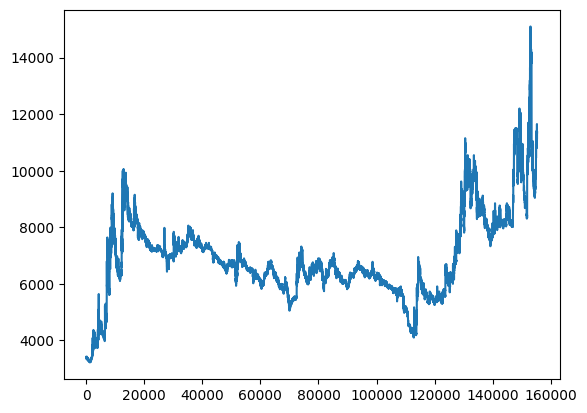

In [8]:
import matplotlib.pyplot as plt

plt.plot(res_df_.close.values)

# plt.plot(res_df_.iloc[:valid_idx[-1]].close)
# plt.plot(res_df_adj_.iloc[:valid_idx[-1]].close)

# plt.plot(res_df_adj_.close)

# legacy

# olds

In [ ]:
# ------ load ftr list ------ #
ticker = 'A005930' # ETH RUNE FTM
data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if ticker in s if '_1.' in s]
print(data_list)

start_0 = time.time()
key = data_list[0]  # tempoaray use single key
# res_df_ = pd.read_csv(os.path.join(data_path, key), index_col=0) # .set_index("index")
res_df_adj_ = pd.read_parquet(os.path.join(data_path, key)) #.set_index("date")
# print(res_df_.head())
print(key, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['20221218 A005930_15_1.parquet']
20221218 A005930_15_1.parquet loaded !
load res_df_ elapsed time : 0.003991842269897461


In [4]:
account_num = kiwoom.GetLoginInfo("ACCOUNT_CNT")        # 전체 계좌수
accounts = kiwoom.GetLoginInfo("ACCNO")                 # 전체 계좌 리스트
user_id = kiwoom.GetLoginInfo("USER_ID")                # 사용자 ID
user_name = kiwoom.GetLoginInfo("USER_NAME")            # 사용자명
keyboard = kiwoom.GetLoginInfo("KEY_BSECGB")            # 키보드보안 해지여부
firewall = kiwoom.GetLoginInfo("FIREW_SECGB")           # 방화벽 설정 여부

print(account_num)
print(accounts)
print(user_id)
print(user_name)
print(keyboard)
print(firewall)

1
['8037568711']
nave94
장재원
0
0


In [83]:
kospi = kiwoom.GetCodeListByMarket('0')
kosdaq = kiwoom.GetCodeListByMarket('10')
etf = kiwoom.GetCodeListByMarket('8')

print(len(kospi))# , kospi)
print(len(kosdaq))# , kosdaq)
print(len(etf))# , etf)

1962
1616
663


In [84]:
name = kiwoom.GetMasterCodeName(code_str)
stock_cnt = kiwoom.GetMasterListedStockCnt(code_str)
stock_const = kiwoom.GetMasterConstruction(code_str)

print(name)
print(stock_cnt)
print(stock_const)

삼성전자
2147483647
정상


In [ ]:
trcode = "opt10019" # opt10001"

df = kiwoom.block_request(trcode,
                          종목코드="005930",
                          output="주식기본정보",
                          next=0)

In [32]:
df.columns

Index(['종목코드', '종목명', '결산월', '액면가', '자본금', '상장주식', '신용비율', '연중최고', '연중최저',
       '시가총액', '시가총액비중', '외인소진률', '대용가', 'PER', 'EPS', 'ROE', 'PBR', 'EV',
       'BPS', '매출액', '영업이익', '당기순이익', '250최고', '250최저', '시가', '고가', '저가',
       '상한가', '하한가', '기준가', '예상체결가', '예상체결수량', '250최고가일', '250최고가대비율',
       '250최저가일', '250최저가대비율', '현재가', '대비기호', '전일대비', '등락율', '거래량', '거래대비',
       '액면가단위', '유통주식', '유통비율'],
      dtype='object')

In [ ]:
import numpy as np
import time

kospi_data = []
kosdag_data = []
etf_data = []

# df.values
for code_str_ in (kospi):
    print(code_str_)
    kospi_data.append(kiwoom.block_request("opt10001",
                          종목코드=code_str_,
                          output="주식기본정보",
                          next=0).values)
    time.sleep(0.5)

In [ ]:
np.array(kospi_data).shape
kospi_data